In [1]:
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

client = Client(processes=False)

Dask client: <bound method Client.__repr__ of <Client: scheduler='inproc://192.168.1.11/40323/1' processes=1 cores=4>>


In [6]:
def load_raw_data():
    df = dd.read_csv("../data/raw/Eluvio_DS_Challenge.csv", blocksize=64000000)
    df.time_created = df.time_created.astype('uint32')
    df.up_votes = df.up_votes.astype('uint16')
    df.down_votes = df.down_votes.astype('uint16')

    df = client.persist(df)
    print df.dtypes
    return df
df = load_raw_data()

time_created    uint32
date_created    object
up_votes        uint16
down_votes      uint16
title           object
over_18           bool
author          object
category        object
dtype: object


[(u'china', 26397), (u'says', 25432), (u'new', 23388), (u'syria', 19023), (u'russia', 18766), (u'world', 18091), (u'police', 16654), (u'government', 16305), (u'israel', 16048), (u'iran', 15816), (u'president', 15271), (u'killed', 14328), (u'people', 13991), (u'state', 13489), (u'attack', 12925)]


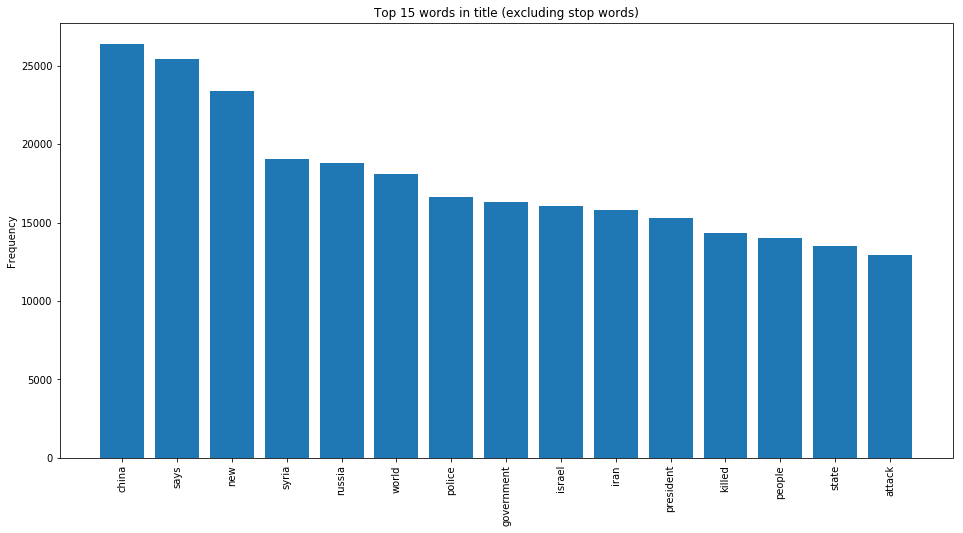

In [5]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

N = 15
titles = df['title']
top_N_words = get_top_n_words(titles.compute(), n=N)
print top_N_words

fig, ax = plt.subplots(figsize=(16, 8))
words = [x[0] for x in top_N_words]
ax.bar(range(N), [x[1] for x in top_N_words])
ax.set_xticks(range(N))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top 15 words in title (excluding stop words)')
ax.set_ylabel('Frequency')
plt.show()